In [1]:

%pprint
import sys
sys.path.insert(1, osp.join(os.pardir, 'py'))

Pretty printing has been turned OFF


In [2]:

import os.path as osp
shared_folder = osp.abspath(osp.join(os.pardir, 'share')); assert osp.exists(shared_folder)
import sys
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join(os.pardir, 'data')),
    saves_folder_path=osp.abspath(osp.join(os.pardir, 'saves'))
)

# Import needed libraries
import re
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from matplotlib.patches import Rectangle
import wikipedia
bs = wikipedia.BeautifulSoup
import numpy as np

In [3]:

generations_df = nu.load_object('generations_df')
turning_numbers_df = nu.load_object('turning_numbers_df')
turnings_df = nu.load_object('turnings_df')


# Technological Preeminence

In [4]:

from io import StringIO

text_str = '''1960,John Bardeen
1960,Jack Kilby
1960,Robert Noyce
1960,Grace Hopper
1960,Gene Amdahl
1960,Douglas Engelbart
1970,Bill Gates
1970,Steve Jobs
1970,Gary Kildall
1970,Alan Kay
1980,Charles Simonyi
1980,Tim Berners-Lee
1980,Marc Andreessen
1990,Larry Page
1990,Sergey Brin
1990,Jerry Yang
1990,David Filo
1990,Jeff Bezos
2000,Mark Zuckerberg
2000,Steve Jobs
2000,Elon Musk
2010,Satya Nadella
2010,Reed Hastings
2010,Jack Ma'''
tech_bros_df = pd.read_csv(StringIO(text_str), header=None, names=['preeminence_decade', 'individual_name'])
display(tech_bros_df.sample(20).T)

,11,21,23,8,18,2,15,19,22,3,17,4,1,9,13,5,20,7,14,6
preeminence_decade,1980,2010,2010,1970,2000,1960,1990,2000,2010,1960,1990,1960,1960,1970,1990,1960,2000,1970,1990,1970
individual_name,Tim Berners-Lee,Satya Nadella,Jack Ma,Gary Kildall,Mark Zuckerberg,Robert Noyce,Jerry Yang,Steve Jobs,Reed Hastings,Grace Hopper,Jeff Bezos,Gene Amdahl,Jack Kilby,Alan Kay,Larry Page,Douglas Engelbart,Elon Musk,Steve Jobs,Sergey Brin,Bill Gates


In [5]:

bio_title = 'Tim Berners-Lee'
nu.get_wiki_infobox_data_frame([bio_title], verbose=True).T.to_dict()[0]

{'page_title': 'Tim Berners-Lee', 'born': 'Timothy John Berners-Lee (1955-06-08) 8 June 1955 (age 68) London, England', 'other_names': 'TimBL TBL', 'education': "The Queen's College, Oxford (BA)", 'known_for': 'Invention of the World Wide Web', 'spouses': 'Nancy Carlson (m. 1990; div. 2011) Rosemary Leith (m. 2014)', 'children': '2 children; 3 step-children', 'parent_s': 'Conway Berners-Lee Mary Lee Woods', 'awards': 'Turing Award (2016) Queen Elizabeth Prize (2013) Foreign Associate of the National Academy of Sciences (2009) Order of Merit (2007) ACM Software System Award (1995)', 'institutions': 'CERN Massachusetts Institute of Technology World Wide Web Consortium University of Oxford University of Southampton', 'website': 'w3.org/People/Berners-Lee/'}

In [24]:

# Create the tech_bro bios data frame from the first table
if nu.pickle_exists('tech_bro_bios_df'): tech_bro_bios_df = nu.load_object('tech_bro_bios_df')
else:
    tech_bro_bios_df = nu.get_wiki_infobox_data_frame(tech_bros_df.individual_name.unique())

    # Remove duplicate columns
    if 'doctoral_advisor' in tech_bro_bios_df.columns:
        columns_list = ['doctoral_advisor', 'doctoral_advisors']
        tech_bro_bios_df = nu.modalize_columns(tech_bro_bios_df, columns_list, 'doctoral_advisors').drop(columns=['doctoral_advisor'])
    if 'occupation_s' in tech_bro_bios_df.columns:
        columns_list = ['occupation', 'occupation_s']
        tech_bro_bios_df = nu.modalize_columns(tech_bro_bios_df, columns_list, 'occupations').drop(columns=columns_list)
    if 'parent_s' in tech_bro_bios_df.columns:
        columns_list = ['parent_s', 'parents']
        tech_bro_bios_df = nu.modalize_columns(tech_bro_bios_df, columns_list, 'parents').drop(columns=['parent_s'])
    if 'partner_s' in tech_bro_bios_df.columns:
        columns_list = ['partner', 'partner_s']
        tech_bro_bios_df = nu.modalize_columns(tech_bro_bios_df, columns_list, 'partners').drop(columns=columns_list)
    if 'spouse_s' in tech_bro_bios_df.columns:
        columns_list = ['spouse', 'spouse_s', 'spouses']
        tech_bro_bios_df = nu.modalize_columns(tech_bro_bios_df, columns_list, 'spouses').drop(columns=['spouse', 'spouse_s'])
    
    # Compute year of birth and death
    mask_series = tech_bro_bios_df.born.isnull()
    assert not mask_series.any(), "You've got a birth problem"
    years_regex = re.compile(r'\d{4}')
    tech_bro_bios_df['year_of_birth'] = tech_bro_bios_df.born.map(lambda x: int(years_regex.findall(x)[0]))
    tech_bro_bios_df['year_of_death'] = tech_bro_bios_df.died.map(lambda x: int(years_regex.findall(x)[0]), na_action='ignore')
    
    nu.store_objects(tech_bro_bios_df=tech_bro_bios_df)

In [38]:

if nu.pickle_exists('tech_bros_df'): tech_bros_df = nu.load_object('tech_bros_df')
else:
    # for bio_title in tech_bros_df.individual_name.unique():
    
    # Get integer columns
    year_regex = re.compile(r'\d{4}(?!s)')
    for individual_name in tech_bros_df.individual_name:
        main_mask_series = (tech_bros_df.individual_name == individual_name)
        bio_mask_series = (tech_bro_bios_df.page_title == individual_name)
        
        # Get year of birth
        year_of_birth = tech_bro_bios_df[bio_mask_series].year_of_birth
        tech_bros_df.loc[main_mask_series, 'year_of_birth'] = year_of_birth
        
        # Get year of death
        year_of_death = tech_bro_bios_df[bio_mask_series].year_of_death
        tech_bros_df.loc[main_mask_series, 'year_of_death'] = year_of_death
        
        # Get the first year of notoriety
        bio_obj = wikipedia.WikipediaPage(title=individual_name)
        years_list = [int(year) for year in years_regex.findall(bio_obj.summary)]
        if len(years_list) > 1: tech_bros_df.loc[main_mask_series, 'year_notoriety_begin'] = sorted(years_list)[1]
        else:
            search_strs_list = re.split(r'\bpublic eye\b', bio_obj.content, 0)

            # Get the last year of the first chunk, or the first year of the last chunk
            if len(search_strs_list) == 2:
                years_list = [int(year) for year in years_regex.findall(search_strs_list[0])]
                if years_list: tech_bros_df.loc[main_mask_series, 'year_notoriety_begin'] = years_list[-1]
                else:
                    years_list = [int(year) for year in years_regex.findall(search_strs_list[1])]
                    if years_list: tech_bros_df.loc[main_mask_series, 'year_notoriety_begin'] = years_list[0]
                    else: display(bio_obj.content); raise
                    
            else:
                search_strs_list = re.split(r'== Career ==', bio_obj.content, 0)
                if len(search_strs_list) == 2: tech_bros_df.loc[main_mask_series, 'year_notoriety_begin'] = [int(year) for year in years_regex.findall(search_strs_list[1])][0]
                else: display(bio_obj.content); raise
    
    # Add generation name and turnings archetype
    for row_index, row_series in tech_bros_df.iterrows():
        year_of_birth = row_series.year_of_birth
        mask_series = (generations_df.birth_year_begin <= year_of_birth) & (generations_df.birth_year_end >= year_of_birth)
        if (generations_df[mask_series].shape[0] >= 1):
            generation_name = generations_df[mask_series].index.tolist()[0]
            turnings_archetype = generations_df[mask_series].turnings_archetype.tolist()[0]
        elif (generations_df[mask_series].shape[0] == 2): display(generations_df[mask_series].index); display(row_series); raise
        else:
            generation_name = np.nan
            turnings_archetype = np.nan
        tech_bros_df.loc[row_index, 'generation_name'] = generation_name
        tech_bros_df.loc[row_index, 'turnings_archetype'] = turnings_archetype
    
    # Add turning number, name, and type
    for row_index, row_series in tech_bros_df.iterrows():
        year_notoriety_begin = row_series.year_notoriety_begin
        mask_series = (turnings_df.turning_year_begin <= year_notoriety_begin) & (turnings_df.turning_year_end >= year_notoriety_begin)
        if (turnings_df[mask_series].shape[0] >= 1):
            
            # Get turning name
            turning_name = turnings_df[mask_series].index.tolist()[0]
            
            # Get turning number
            turning_number = turnings_df[mask_series].turning_number.tolist()[0]
            
        elif (turnings_df[mask_series].shape[0] == 2): display(turnings_df[mask_series].index); display(row_series); raise
        else:
            turning_name = np.nan
            turning_number = np.nan
        
        # Get turning type
        mask_series = (turning_numbers_df.index == turning_number)
        if (turning_numbers_df[mask_series].shape[0] >= 1): turning_type = turning_numbers_df[mask_series].turning_type.tolist()[0]
        else: turning_type = np.nan
        
        tech_bros_df.loc[row_index, 'turning_name'] = turning_name
        tech_bros_df.loc[row_index, 'turning_number'] = turning_number
        tech_bros_df.loc[row_index, 'turning_type'] = turning_type

    # Add final computations and make the name the index
    tech_bros_df['age_at_notoriety'] = (tech_bros_df.year_notoriety_begin - tech_bros_df.year_of_birth)
    tech_bros_df.year_notoriety_begin = tech_bros_df.year_notoriety_begin.map(lambda x: int(x))
    tech_bros_df = tech_bros_df.set_index('individual_name')
    
    nu.store_objects(tech_bros_df=tech_bros_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\Strauss-Howe\saves\pkl\tech_bros_df.pkl


In [49]:

mask_series = tech_bros_df.index.duplicated()
tech_bros_df.index[mask_series]

Index(['Steve Jobs'], dtype='object', name='individual_name')

In [48]:

columns_list = ['generation_name']
tech_bros_df.sort_values('year_notoriety_begin')[columns_list]

,generation_name
individual_name,
Grace Hopper,G.I.
Steve Jobs,NaN
Steve Jobs,Baby Boom
John Bardeen,G.I.
Robert Noyce,Silent
Jack Kilby,G.I.
Douglas Engelbart,Silent
Bill Gates,Baby Boom
Gary Kildall,Silent


In [50]:

# Add generation name and turnings archetype
mask_series = tech_bros_df.generation_name.isnull()
for row_index, row_series in tech_bros_df[mask_series].iterrows():
    year_of_birth = row_series.year_of_birth
    print(year_of_birth); continue
    mask_series = (generations_df.birth_year_begin <= year_of_birth) & (generations_df.birth_year_end >= year_of_birth)
    if (generations_df[mask_series].shape[0] >= 1):
        generation_name = generations_df[mask_series].index.tolist()[0]
        turnings_archetype = generations_df[mask_series].turnings_archetype.tolist()[0]
    elif (generations_df[mask_series].shape[0] == 2): display(generations_df[mask_series].index); display(row_series); raise
    else:
        generation_name = np.nan
        turnings_archetype = np.nan
    tech_bros_df.loc[row_index, 'generation_name'] = generation_name
    tech_bros_df.loc[row_index, 'turnings_archetype'] = turnings_archetype

nan
nan
nan
nan
nan


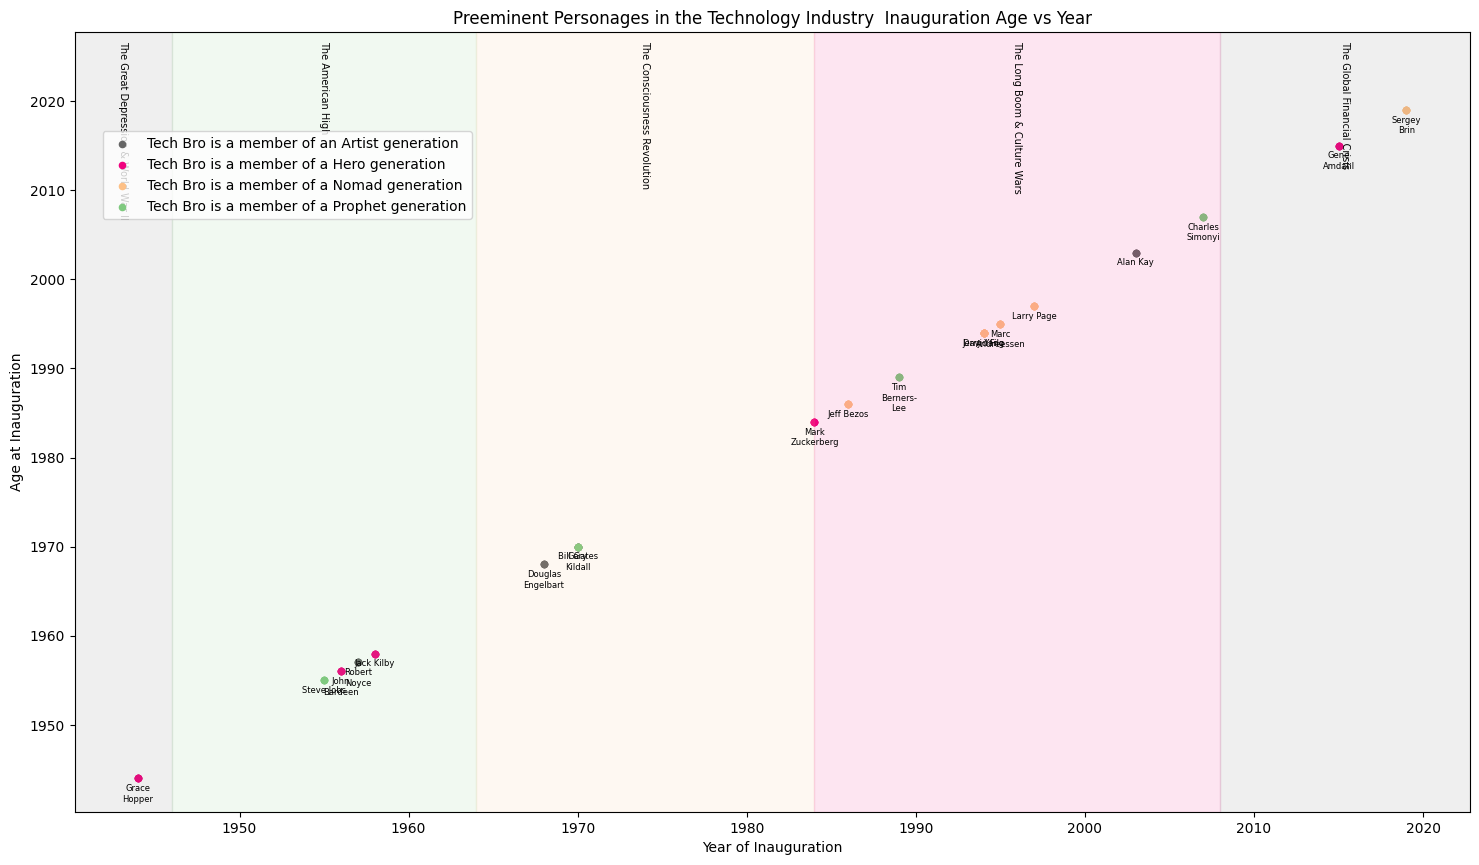

In [43]:

df1 = turnings_df.reset_index()
df2 = generations_df.reset_index()
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
tech_bros_df['office_rank'] = tech_bros_df.year_notoriety_begin
tech_bros_df['age_at_inauguration'] = tech_bros_df.year_notoriety_begin
nu.plot_inauguration_age(
    inauguration_df=tech_bros_df, groupby_column_name='turnings_archetype', xname='year_notoriety_begin', leader_designation='Tech Bro',
    label_infix='is a member of', label_suffix='generation', info_df=df3,
    title_prefix='Preeminent Personages in the Technology Industry '
)

In [ ]:

df1 = turnings_df.reset_index()
df2 = turning_numbers_df.reset_index().rename(columns={'index': 'turning_number'})
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
df4 = generations_df.reset_index()
on_list = list(set(df3.columns).intersection(set(df4.columns)))
df5 = df3.merge(df4, on=on_list)
nu.plot_inauguration_age(
    inauguration_df=tech_bros_df, groupby_column_name='turning_type', xname='year_notoriety_begin', leader_designation='Inaugurated',
    label_infix='during', label_suffix='', info_df=df5,
    title_prefix='United States tech_bros from Massachusetts'
)


----

In [33]:

search_str = 'public eye'
for individual_name in tech_bros_df.individual_name:
    bio_obj = wikipedia.WikipediaPage(title=individual_name)
    content = bio_obj.content
    if search_str not in content: print(f'Need another search term for {individual_name}')
    else:
        eyes_list = re.compile(r'[^\r\n]*' + search_str + r'[^\r\n]*').findall(content)
        print(f'Eyes list for {individual_name}:')
        for eye_str in eyes_list: print(eye_str.strip())

Need another search term for John Bardeen
Need another search term for Jack Kilby
Need another search term for Robert Noyce
Need another search term for Grace Hopper
Need another search term for Gene Amdahl
Need another search term for Douglas Engelbart
Need another search term for Bill Gates
Need another search term for Steve Jobs
Need another search term for Gary Kildall
Need another search term for Alan Kay
Need another search term for Charles Simonyi
Need another search term for Tim Berners-Lee
Eyes list for Marc Andreessen:
After his graduation from UIUC in 1993, Andreessen moved to California to work at Enterprise Integration Technologies. Andreessen then met with Jim Clark, the founder of Silicon Graphics, who had recently exited the firm.  Clark believed the Mosaic browser had great commercial possibilities and suggested starting an Internet software company.  Soon, Mosaic Communications Corporation was in business in Mountain View, California, with Andreessen as co-founder and

In [34]:

page_title = 'Lists of covers of Time magazine'
page_obj = wikipedia.WikipediaPage(title=page_title)
page_obj.links

['Canadian Newsmaker of the Year (Time)', 'Heroes of the Environment', 'Heroes of the Environment (2007)', 'Heroes of the Environment (2008)', 'Heroes of the Environment (2009)', 'List of covers of Time magazine (1920s)', 'List of covers of Time magazine (1930s)', 'List of covers of Time magazine (1940s)', 'List of covers of Time magazine (1950s)', 'List of covers of Time magazine (1960s)', 'List of covers of Time magazine (1970s)', 'List of covers of Time magazine (1980s)', 'List of covers of Time magazine (1990s)', 'List of covers of Time magazine (2000s)', 'List of covers of Time magazine (2010s)', 'List of covers of Time magazine (2020s)', 'News magazine', 'Time (magazine)', 'Time 100', 'Time 100: The Most Important People of the Century', 'Time Person of the Year', 'You (Time Person of the Year)']